In [1]:

import math
from collections import Counter
import json

import matplotlib
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset



In [2]:

from IPython.display import display as d
# from IPython.display import Image



In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
!wget -nc http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip
!unzip -n cornell_movie_dialogs_corpus.zip
!ls

File ‘cornell_movie_dialogs_corpus.zip’ already there; not retrieving.

Archive:  cornell_movie_dialogs_corpus.zip
'cornell movie-dialogs corpus'	    __MACOSX		 sample_data
 cornell_movie_dialogs_corpus.zip   pairs_encoded.json	 WORDMAP_corpus.json


In [5]:
corpus_movie_conv = 'cornell movie-dialogs corpus/movie_conversations.txt'
corpus_movie_lines = 'cornell movie-dialogs corpus/movie_lines.txt'
max_len = 25

In [6]:
with open(corpus_movie_conv, 'r') as c:
    conv = c.readlines()

In [7]:
# with open(corpus_movie_lines, 'r') as l:
with open(corpus_movie_lines, 'r', encoding='iso-8859-1') as l:
    lines = l.readlines()

In [8]:
print('length: ', len(conv), '\n')
conv[:10]

length:  83097 



["u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L198', 'L199']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L200', 'L201', 'L202', 'L203']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L204', 'L205', 'L206']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L207', 'L208']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L271', 'L272', 'L273', 'L274', 'L275']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L276', 'L277']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L280', 'L281']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L363', 'L364']\n",
 "u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L365', 'L366']\n"]

In [9]:
print('length: ', len(lines), '\n')
lines[:10]

length:  304713 



['L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n',
 'L1044 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ They do to!\n',
 'L985 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I hope so.\n',
 'L984 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ She okay?\n',
 "L925 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Let's go.\n",
 'L924 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ Wow\n',
 "L872 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Okay -- you're gonna need to learn how to lie.\n",
 'L871 +++$+++ u2 +++$+++ m0 +++$+++ CAMERON +++$+++ No\n',
 'L870 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n',
 'L869 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ Like my fear of wearing pastels?\n']

In [10]:
d(lines[0])
d(lines[0].split(' +++$+++ '))

'L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!\n'

['L1045', 'u0', 'm0', 'BIANCA', 'They do not!\n']

In [11]:
d(lines[0].split(' +++$+++ ')[0])
d(lines[0].split(' +++$+++ ')[-1])

'L1045'

'They do not!\n'

In [12]:
lines_dic = {}
for line in lines:
    objects = line.split(' +++$+++ ')
    lines_dic[objects[0]] = objects[-1]

In [13]:
list(lines_dic.items())[:10]

[('L1045', 'They do not!\n'),
 ('L1044', 'They do to!\n'),
 ('L985', 'I hope so.\n'),
 ('L984', 'She okay?\n'),
 ('L925', "Let's go.\n"),
 ('L924', 'Wow\n'),
 ('L872', "Okay -- you're gonna need to learn how to lie.\n"),
 ('L871', 'No\n'),
 ('L870',
  'I\'m kidding.  You know how sometimes you just become this "persona"?  And you don\'t know how to quit?\n'),
 ('L869', 'Like my fear of wearing pastels?\n')]

In [14]:
lines_dic['L194']

'Can we make this quick?  Roxanne Korrine and Andrew Barrett are having an incredibly horrendous public break- up on the quad.  Again.\n'

In [15]:
def remove_punc(string):
    punctuations = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    no_punct = ''
    for char in string:
        if char not in punctuations:
            no_punct += char  # space is also a character

    return no_punct.lower()


In [16]:
remove_punc('tgyusj!(@)ihdys')

'tgyusjihdys'

In [17]:
d(conv[0])
d(conv[0].split(' +++$+++ '))
d(conv[0].split(' +++$+++ ')[-1])
type(conv[0].split(' +++$+++ ')[-1])

"u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']\n"

['u0', 'u2', 'm0', "['L194', 'L195', 'L196', 'L197']\n"]

"['L194', 'L195', 'L196', 'L197']\n"

str

In [18]:
eval(conv[0].split(' +++$+++ ')[-1])

['L194', 'L195', 'L196', 'L197']

In [19]:
type(eval(conv[0].split(' +++$+++ ')[-1]))

list

In [20]:
len(eval(conv[0].split(' +++$+++ ')[-1]))

4

In [21]:
lines_dic['L197']

"Okay... then how 'bout we try out some French cuisine.  Saturday?  Night?\n"

In [22]:
remove_punc(lines_dic['L197'])

'okay then how bout we try out some french cuisine  saturday  night\n'

In [23]:

pairs = []    # question and answers pairs

for con in conv:
    ids = eval(con.split(" +++$+++ ")[-1])    # ['L194', 'L195', 'L196', 'L197']

    for i in range(len(ids)):
        qa_pairs = []

        if i == len(ids) - 1:
            break

        first = remove_punc(lines_dic[ids[i]].strip())    #'okay then how bout we try out some french cuisine  saturday  night'
        second = remove_punc(lines_dic[ids[i+1]].strip())

        qa_pairs.append(first.split()[:max_len])    # ['okay, then, how, bout, we, try, out, some, french, cuisine, saturday, night']
        qa_pairs.append(second.split()[:max_len])

        pairs.append(qa_pairs)



In [24]:
print('length: ', len(pairs), '\n')
print(pairs[0])
print('\n')
print(pairs[0][0])
print('\n')
print(pairs[0][1])

length:  221616 

[['can', 'we', 'make', 'this', 'quick', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', 'again'], ['well', 'i', 'thought', 'wed', 'start', 'with', 'pronunciation', 'if', 'thats', 'okay', 'with', 'you']]


['can', 'we', 'make', 'this', 'quick', 'roxanne', 'korrine', 'and', 'andrew', 'barrett', 'are', 'having', 'an', 'incredibly', 'horrendous', 'public', 'break', 'up', 'on', 'the', 'quad', 'again']


['well', 'i', 'thought', 'wed', 'start', 'with', 'pronunciation', 'if', 'thats', 'okay', 'with', 'you']


In [25]:

word_freq = Counter()

for pair in pairs:
    word_freq.update(pair[0])
    word_freq.update(pair[1])



In [26]:
list(word_freq.items())[:10]

[('can', 14103),
 ('we', 25912),
 ('make', 5821),
 ('this', 30502),
 ('quick', 310),
 ('roxanne', 1),
 ('korrine', 1),
 ('and', 52131),
 ('andrew', 49),
 ('barrett', 20)]

In [27]:
min_word_freq = 5
words = [w for w in word_freq.keys() if word_freq[w] > min_word_freq]
words[:10]

['can',
 'we',
 'make',
 'this',
 'quick',
 'and',
 'andrew',
 'barrett',
 'are',
 'having']

In [28]:

# word_map = {k: idx + 1 for idx, k in enumerate(words)}
word_map = {k: idx for idx, k in enumerate(words, start=1)}



word_map['<start>'] = len(word_map) + 1      # len(word_map) increases after each step
word_map['<end>']   = len(word_map) + 1
word_map['<unk>']   = len(word_map) + 1
word_map['<pad>']   = 0





In [29]:
list(word_map.items())[:10]

[('can', 1),
 ('we', 2),
 ('make', 3),
 ('this', 4),
 ('quick', 5),
 ('and', 6),
 ('andrew', 7),
 ('barrett', 8),
 ('are', 9),
 ('having', 10)]

In [30]:
print(f"Total words are: {len(word_map)}")

Total words are: 18243


In [31]:

with open('WORDMAP_corpus.json', 'w') as j:    # save word_map as json file
    json.dump(word_map, j)



In [32]:

def encode_question(words, word_map):

    # encode words and pad short sentences
    enc_c = [word_map.get(word, word_map['<unk>']) for word in words] \
            + [word_map['<pad>']] * (max_len - len(words))

    return enc_c



In [33]:

def encode_reply(words, word_map):

    enc_c = [word_map['<start>']] \
            + [word_map.get(word, word_map['<unk>']) for word in words] \
            + [word_map['<end>']] \
            + [word_map['<pad>']] * (max_len - len(words))


    return enc_c



In [34]:

pairs_encoded = []
c = 0

for pair in pairs:

    if not (any(pair[0]) and any(pair[1])):       # any([]) and any(['newer', 'more', 'powerful', 'design']) --> False
        c += 1
        continue


    qus = encode_question(pair[0], word_map)
    ans = encode_reply(pair[1], word_map)

    pairs_encoded.append([qus, ans])


print('empty: ', c)
print('pairs_encoded length: ', len(pairs_encoded))



empty:  342
pairs_encoded length:  221274


In [35]:
print(pairs_encoded[0][0])
print('\n')
print(pairs_encoded[0][1])

[1, 2, 3, 4, 5, 18242, 18242, 6, 7, 8, 9, 10, 11, 12, 18242, 13, 14, 15, 16, 17, 18242, 18, 0, 0, 0]


[18240, 19, 20, 21, 22, 23, 24, 18242, 25, 26, 27, 24, 28, 18241, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [36]:

with open('pairs_encoded.json', 'w') as p:
    json.dump(pairs_encoded, p)


In [37]:
# rev_word_map = {v: k for k, v in word_map.items()}
# ' '.join([rev_word_map[v] for v in pairs_encoded[1][0]])

In [38]:

class Dataset(Dataset):

    def __init__(self):

        self.pairs = json.load(open('pairs_encoded.json'))
        self.dataset_size = len(self.pairs)

    def __getitem__(self, i):

        question = torch.LongTensor(self.pairs[i][0])
        reply = torch.LongTensor(self.pairs[i][1])

        return question, reply

    def __len__(self):
        return self.dataset_size



In [39]:

train_loader = torch.utils.data.DataLoader(Dataset(),

                                           # batch_size=100,
                                           batch_size=64,
                                           # batch_size=32,
                                           # batch_size=16,
                                           # batch_size=4,
                                           # batch_size=1,

                                           shuffle=True,
                                           pin_memory=True)



In [40]:

# question, reply = next(iter(train_loader))

# print(question.shape)
# print(reply.shape)

# # torch.Size([64, 25])
# # torch.Size([64, 27])


In [41]:

# print(question[0].shape)
# question[0]

# # torch.Size([25])
# # tensor([  45,  155,   91,   92,   16,   17, 6683,   24,  125, 3712,  533,  593,
# #            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
# #            0])


In [42]:

# question[0] != 0

# # tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
# #          True,  True, False, False, False, False, False, False, False, False,
# #         False, False, False, False, False])


In [43]:
torch.ones(5, 5)

tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]])

In [44]:
torch.tril(torch.ones(5, 5)).type(dtype=torch.uint8)

tensor([[1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0],
        [1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1]], dtype=torch.uint8)

In [45]:
def create_masks(question, reply_input, reply_target):

    def subsequent_mask(size):
        mask = torch.tril(torch.ones(size, size)).type(dtype=torch.uint8)    # (max_words, max_words)
        return mask.unsqueeze(0)    # (1, max_words, max_words)


    # question : I went home, mask = (batch_size, 1, 1, max_words)

    # sentence_reply : <start>   I     went   home   <end>
    # reply_input    : <start>   I     went   home,           mask = (batch_size, 1, max_words, max_words)
    # reply_target   :   I      went   home   <end>,          mask = (batch_size, max_words)


    question_mask = question != 0
    question_mask = question_mask.to(device)
    question_mask = question_mask.unsqueeze(1).unsqueeze(1)    # (batch_size, 1, 1, max_words)



    reply_input_mask = reply_input != 0
    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words)

    reply_input_mask = reply_input_mask & subsequent_mask(reply_input.size(-1)).type_as(reply_input_mask.data)
    # (batch_size, 1, max_words) & (1, max_words, max_words) --> (batch_size, max_words, max_words)

    reply_input_mask = reply_input_mask.unsqueeze(1)  # (batch_size, 1, max_words, max_words)



    reply_target_mask = reply_target != 0    # (batch_size, max_words), used in loss function



    # question_mask     : (batch_size, 1, 1, max_words)
    # reply_input_mask  : (batch_size, 1, max_words, max_words)
    # reply_target_mask : (batch_size, max_words)

    return question_mask, reply_input_mask, reply_target_mask




In [46]:
class Embeddings(nn.Module):
    """
    Implements embeddings of the words and adds their positional encodings.
    """
    def __init__(self, vocab_size, d_model, max_len=50, num_layers=6):
        super(Embeddings, self).__init__()

        self.d_model = d_model

        self.embed = nn.Embedding(vocab_size, d_model)

        self.pe = self.create_positinal_encoding(max_len, self.d_model)     # (1, max_len, d_model)
        self.te = self.create_positinal_encoding(num_layers, self.d_model)  # (1, num_layers, d_model)

        self.dropout = nn.Dropout(0.1)



    def create_positinal_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model).to(device)
        for pos in range(max_len):   # for each position of the word
            for i in range(0, d_model, 2):   # for each dimension of the each position
                pe[pos, i]     = math.sin(pos / (10000 ** ((2 * i)/d_model)))
                pe[pos, i + 1] = math.cos(pos / (10000 ** ((2 * (i + 1))/d_model)))

        pe = pe.unsqueeze(0)   # include the batch size, (1, max_len, d_model)

        return pe




    def forward(self, embedding, layer_idx):

        if layer_idx == 0:
            embedding = self.embed(embedding) * math.sqrt(self.d_model) # run in first time step only
                                                                        # multiply by * math.sqrt(self.d_model) to give
                                                                        # more meaning to words than positinal encodings
                                                                        # (batch_size, max_words, d_model)

        # max_words = embedding.size(1)
        embedding += self.pe[:, :embedding.size(1)]   # trim as max_len=50 in __init__ or passed arg
                                                      # pe will automatically be expanded with the same batch size as encoded_words
                                                      # (batch_size, max_words, d_model) + (1, max_words, d_model)



        # embedding: (batch_size, max_len, d_model)

        # te:        (1, max_len, d_model) --> (batch_size, d_model)
        #             --> (batch_size, 1, d_model) --> (batch_size, max_len, d_model)

        embedding += self.te[:, layer_idx, :].unsqueeze(1).repeat(1, embedding.size(1), 1)



        embedding = self.dropout(embedding)


        return embedding




In [47]:
a = torch.randn((2, 2))
a

tensor([[1.1888, 1.0553],
        [2.0154, 1.3902]])

In [48]:
m = torch.tensor([[1, 0], [0, 1]])
m

tensor([[1, 0],
        [0, 1]])

In [49]:
a.masked_fill(m == 0, 0)

tensor([[1.1888, 0.0000],
        [0.0000, 1.3902]])

In [50]:
class MultiHeadAttention(nn.Module):

    def __init__(self, heads, d_model):

        super(MultiHeadAttention, self).__init__()

        assert (d_model % heads) == 0

        self.d_k = d_model // heads
        self.heads = heads

        self.query = nn.Linear(d_model, d_model)
        self.key   = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)

        self.concat = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(0.1)




    def forward(self, query, key, value, mask):
        """
        query, key, value of shape: (batch_size, max_len, d_model) || (batch_size, max_len, 512)
        mask of shape: (batch_size, 1, 1, max_words)
                       (batch_size, 1, max_words, max_words)
        """
        # (batch_size, max_len, d_model)
        query = self.query(query)
        key   = self.key(key)
        value = self.value(value)

        # (batch_size, max_len, d_model) --> (batch_size, max_len, h, d_k) --> (batch_size, h, max_len, d_k)
        #                                                          8   64                   8            64
        query = query.view(query.size(0), -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        key   = key.view(key.size(0), -1, self.heads, self.d_k).permute(0, 2, 1, 3)
        value = value.view(value.size(0), -1, self.heads, self.d_k).permute(0, 2, 1, 3)


        # (batch_size, h, max_len, d_k) dot (batch_size, h, max_len, d_k).transpose()
        # (batch_size, h, max_len, d_k) matmul (batch_size, h, d_k, max_len) --> (batch_size, h, max_len, max_len)
        scores = torch.matmul(query, key.permute(0, 1, 3, 2)) / math.sqrt(query.size(-1)) # query.size(-1) = d_k

        scores = scores.masked_fill(mask == 0, -1e9)    # (batch_size, h, max_len, max_len)
                                                        # '-1e9' as a tiny value that softmax ignore them,
                                                        # not doing the attention operation on 'padded' values

        weights = F.softmax(scores, dim=-1)    # (batch_size, h, max_len, max_len)
        weights = self.dropout(weights)


        # (batch_size, h, max_len, max_len) matmul (batch_size, h, max_len, d_k) --> (batch_size, h, max_len, d_k)
        context = torch.matmul(weights, value)

        # (batch_size, h, max_len, d_k) --> (batch_size, max_len, h, d_k) --> (batch_size, max_len, h * d_k)
        context = context.permute(0, 2, 1, 3).contiguous().view(context.size(0), -1, self.heads * self.d_k)

        # (batch_size, max_len, h * d_k)
        interacted = self.concat(context)



        return interacted




In [51]:
class FeedForward(nn.Module):

    def __init__(self, d_model, middle_dim=2048):    # middle_dim = d_model * 4
        super(FeedForward, self).__init__()

        self.fc1 = nn.Linear(d_model, middle_dim)
        self.fc2 = nn.Linear(middle_dim, d_model)
        self.dropout = nn.Dropout(0.1)


    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = self.fc2(self.dropout(out))
        return out



In [52]:
class EncoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(EncoderLayer, self).__init__()

        self.self_multihead = MultiHeadAttention(heads, d_model)

        self.feed_forward = FeedForward(d_model, middle_dim=2048)

        self.layernorm = nn.LayerNorm(d_model)    # d_model = 512
        self.dropout = nn.Dropout(0.1)




    def forward(self, embeddings, mask):
                                                    #   query       key         value
        interacted = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, mask))
        interacted = self.layernorm(interacted + embeddings) # add Residual Learning & Norm

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        encoded = self.layernorm(feed_forward_out + interacted)


        return encoded




In [53]:
class DecoderLayer(nn.Module):

    def __init__(self, d_model, heads):
        super(DecoderLayer, self).__init__()

        self.self_multihead = MultiHeadAttention(heads, d_model)    # Masked Multi-Head Attention, attend to its own inputs
        self.src_multihead  = MultiHeadAttention(heads, d_model)    # Multi-Head Attention, attend to Encoder outputs

        self.feed_forward = FeedForward(d_model)

        self.layernorm = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(0.1)




    def forward(self, embeddings, target_mask, encoded, src_mask):

        # (decoder_input_query, decoder_input_key, decoder_input_value, decoder_input_mask)
        query = self.dropout(self.self_multihead(embeddings, embeddings, embeddings, target_mask))
        query = self.layernorm(query + embeddings) # add Residual Learning & Norm

        # (query -> self_attention from Decoder), (key and value -> encoded from Encoder)
        # (decoder_input_query, encoder_output_key, encoder_output_value, decoder_src_mask)
        interacted = self.dropout(self.src_multihead(query, encoded, encoded, src_mask))    # notice mask here, Encoder mask
        # (query = query), (key and value = encoded)
        interacted = self.layernorm(interacted + query)

        feed_forward_out = self.dropout(self.feed_forward(interacted))
        decoded = self.layernorm(feed_forward_out + interacted)


        return decoded




In [54]:
class Transformer(nn.Module):

    def __init__(self, d_model, heads, num_layers, word_map, max_len=50):
        super(Transformer, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers
        self.vocab_size = len(word_map)

        self.embed = Embeddings(self.vocab_size, d_model, max_len=max_len, num_layers=num_layers)
        self.encoder = EncoderLayer(d_model, heads)
        self.decoder = DecoderLayer(d_model, heads)

        self.logit = nn.Linear(d_model, self.vocab_size)



    def encode(self, src_embeddings, src_mask):
        for i in range(self.num_layers):
            src_embeddings = self.embed(src_embeddings, layer_idx=i)
            src_embeddings = self.encoder(src_embeddings, src_mask)
        return src_embeddings



    def decode(self, tgt_embeddings, tgt_mask, src_embeddings, src_mask):
        for i in range(self.num_layers):
            tgt_embeddings = self.embed(tgt_embeddings, layer_idx=i)
            tgt_embeddings = self.decoder(tgt_embeddings, tgt_mask, src_embeddings, src_mask)
        return tgt_embeddings




    def forward(self, src_words, src_mask, target_words, target_mask):
        encoded = self.encode(src_words, src_mask)
        decoded = self.decode(target_words, target_mask, encoded, src_mask)
        out = F.log_softmax(self.logit(decoded), dim=2)    # (batch_size, max_words, vocab_size)

        return out    # (batch_size, max_words, vocab_size)




In [55]:
class AdamWarmup:

    def __init__(self, model_size, warmup_steps, optimizer):

        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0

        # # self.lr = 0
        # self.lr = optimizer.param_groups[-1]['lr']
        # # self.lr = optimizer.state_dict()['param_groups'][0]['lr']
        self.lr = None

        # self.current_epoch = 0




    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))




    # def step(self, epoch):

    #     if epoch != self.current_epoch:
    #         self.current_epoch = epoch
    #         self.current_step  = 0

    #     # Increment the number of steps each time we call the step function
    #     self.current_step += 1

    #     lr = self.get_lr()
    #     for param_group in self.optimizer.param_groups:
    #         param_group['lr'] = lr

    #     # update the learning rate
    #     self.lr = lr

    #     self.optimizer.step()


    def step(self, epoch):

        # Increment the number of steps each time we call the step function
        self.current_step += 1

        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        # update the learning rate
        self.lr = lr

        self.optimizer.step()




In [56]:
class LossWithLS(nn.Module):

    def __init__(self, size, smooth):
        super(LossWithLS, self).__init__()

        self.criterion = nn.KLDivLoss(size_average=False, reduce=False)
        # self.criterion = nn.KLDivLoss(reduction='none')

        self.confidence = 1.0 - smooth
        self.smooth = smooth
        self.size = size    # size of predection, which is vocab_size



    def forward(self, prediction, target, mask):
        """
        prediction of shape: (batch_size, max_words, vocab_size)
        target and mask of shape: (batch_size, max_words)
        """

        # batch_size = prediction.size(0)
        # max_words  = prediction.size(1)
        # vocab_size = prediction.size(2)

        # prediction = prediction.view(-1, prediction.size(-1))   # (batch_size * max_words, vocab_size)
        # target = target.contiguous().view(-1)   # (batch_size * max_words)

        # mask = mask.float()
        # # mask = mask.view(-1)       # (batch_size * max_words)


        labels = prediction.data.clone()    # (batch_size, max_words, vocab_size)
        labels.fill_(self.smooth / (self.size - 1))

        labels.scatter_(2, target.data.unsqueeze(2), self.confidence)
        # labels[:, self.padding_idx] = 0

        # target.data.unsqueeze(2), (batch_size, max_words) --> (batch_size, max_words, 1)
        # labels,                                               (batch_size, max_words, vocab_size)


        loss = self.criterion(prediction, labels)    # prediction == labels == (batch_size, max_words, vocab_size)




        # # First way
        # loss = (loss.sum(1) * mask).sum() / mask.sum()  # calculate the mean of the loss = masked_sum / n
        #                                                 # loss.sum(1) --> (batch_size * max_words) 1d tensor
        #                                                 # '/ mask.sum()' sum over all the elements in the mask



        # Second way
        # compute entropy (KL Divergence) loss for smoothed labels by summing them as in the equation
        # loss = loss.view(batch_size, max_words, vocab_size).sum(2)
        loss = loss.sum(2)
        # (batch_size, max_words, vocab_size) --> (batch_size, max_words)

        # mask = mask.view(batch_size, max_words)       # (batch_size * max_words) --> (batch_size, max_words)

        # loss.masked_fill_(mask, 0)    # (batch_size, max_words)
        # loss.masked_fill_(~mask, 0)
        loss.masked_fill_(mask == 0, 0)

        # reduction method: 'mean'
        # # loss = loss.mean(1).mean()    # (batch_size, max_words) --> (batch_size) --> scalar XXXXXXX
        # loss = loss.mean()


        n_words = torch.sum(mask != 0, dim=1)     # (batch_size, max_words).sum(dim=1) --> (batch_size)

        loss = loss.sum(1).div(n_words)           # (batch_size, max_words).sum(1) --> (batch_size)
                                                  # (batch_size).div(batch_size) --> (batch_size)
                                                  # mean row by row

        loss = loss.mean()    # (batch_size) --> scalar



        # # reduction method: 'sum'
        # loss = loss.sum(1).mean()
        # loss = loss.sum()





        return loss




In [57]:

d_model = 512

heads = 8


# num_layers = 3
num_layers = 6


# epochs = 10
# epochs = 25
# epochs = 1
# epochs = 2
epochs = 5



with open('WORDMAP_corpus.json', 'r') as w:
    word_map = json.load(w)



transformer = Transformer(d_model=d_model, heads=heads, num_layers=num_layers, word_map=word_map).to(device)

adam_optimizer = torch.optim.Adam(transformer.parameters(), lr=0, weight_decay=0.01, betas=(0.9, 0.98), eps=1e-9)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=4000, optimizer=adam_optimizer)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=3000, optimizer=adam_optimizer)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=3500, optimizer=adam_optimizer)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=2000, optimizer=adam_optimizer)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=1300, optimizer=adam_optimizer)
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=15000, optimizer=adam_optimizer)  # 55404
# transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=650, optimizer=adam_optimizer)  # 3458

# warmup_steps = int((len(train_loader) * epochs) * 0.2)
# warmup_steps = int((len(train_loader) * epochs) * 0.3)
# warmup_steps = int((len(train_loader) * epochs) * 0.4)
warmup_steps = int((len(train_loader) * epochs) * 0.33)
transformer_optimizer = AdamWarmup(model_size=d_model, warmup_steps=warmup_steps, optimizer=adam_optimizer)



# optimizer = torch.optim.Adam(transformer.parameters(), lr=3e-4)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10, verbose=True)




# optimizer = torch.optim.AdamW(transformer.parameters(), lr=5e-5, weight_decay=0.01, betas=(0.9, 0.98), eps=1e-9)

# from transformers.optimization import get_linear_schedule_with_warmup

# # scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=500, num_training_steps=len(train_loader) * epochs)
# # scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=1500, num_training_steps=len(train_loader) * epochs)
# scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, num_warmup_steps=4000, num_training_steps=len(train_loader) * epochs)






# criterion = LossWithLS(len(word_map), 0.3)
criterion = LossWithLS(len(word_map), 0.1)


# criterion = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1).to(device)





/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [58]:
def train(train_loader, transformer, criterion, epoch):

    transformer.train()


    # sum_loss = 0
    # count = 0


    LOSS = []
    LR   = []

    for i, (question, reply) in enumerate(train_loader):

        samples = question.size(0)    # batch_size

        # Move to device
        question = question.to(device)
        reply = reply.to(device)

        # question    : <start>  I     went   home  <end>
        # reply_input : <start>  I     went   home
        # reply_target:   I     went   home   <end>

        # Prepare Target Data
        reply_input = reply[:, :-1] # start .. before <end> token
        reply_target = reply[:, 1:] # after <start> token .. up to <end> token

        # Create mask and add dimensions
        question_mask, reply_input_mask, reply_target_mask = create_masks(question, reply_input, reply_target)

        # Get the transformer outputs
        out = transformer(question, question_mask, reply_input, reply_input_mask)

        # d(out.shape)
        # d(reply_target.shape)

        # Compute the loss
        loss = criterion(out, reply_target, reply_target_mask)
        # loss = criterion(out.contiguous().view(-1, out.size(-1)), reply_target.contiguous().view(-1))

        # Backprop
        transformer_optimizer.optimizer.zero_grad()
        # optimizer.zero_grad()

        loss.backward()

        transformer_optimizer.step(epoch)
        # optimizer.step()
        # scheduler.step()


        # # sum_loss += loss.item() * samples
        # sum_loss += loss.item()

        # count += samples    # at the last batch for an epoch, the count = len(train_loader) * batch_size


        current_lr = transformer_optimizer.optimizer.state_dict()['param_groups'][0]['lr']
        # current_lr = optimizer.state_dict()['param_groups'][0]['lr']

        if i % 100 == 0:
            # print(f"Epoch [{epoch}][{i}/{len(train_loader)}]\tLoss: {sum_loss/count:.3f}")
            print(f"Epoch [{epoch}][{i}/{len(train_loader)}]\tLoss: {loss.item():.3f}\tLR: {current_lr:f}")


        LOSS.append(loss.item())
        LR.append(current_lr)



    # scheduler.step(torch.mean(torch.tensor(LOSS).float()))




    return (LOSS, LR)




In [59]:
def evaluate(transformer, question, question_mask, max_len, word_map):
    """
    Performs Greedy (search) Decoding with a batch_size of 1


    question : <start>  I  went  home  <end>

    reply    : [<start>], new_mask
    reply    : [<start>, prediction1], new_mask
    reply    : [<start>, prediction1, prediction2], new_mask
    reply    : [<start>, prediction1, prediction2, prediction3]

    out      : [prediction1, prediction2, prediction3]

    """


    transformer.eval()


    encoded = transformer.encode(question, question_mask)

    start_token = word_map['<start>']
    words       = torch.LongTensor([[start_token]]).to(device)    # (1, 1)



    for step in range(max_len - 1):

        size = words.size(1)    # (max_len)

        target_mask = torch.tril(torch.ones(size, size)).type(dtype=torch.uint8)    # (max_len, max_len)
        target_mask = target_mask.to(device).unsqueeze(0).unsqueeze(0)              # (1, 1, max_len, max_len)

        decoded = transformer.decode(words, target_mask, encoded, question_mask)
        # decoded is of (batch_size, max_words, vocab_size) --> (1, max_words, vocab_size)

        predictions = transformer.logit(decoded[:, -1])
        # (batch_size, max_words, vocab_size)[:, -1] --> (batch_size, vocab_size)
        # decoded[:, -1] --> prediction of last word (1, vocab_size)

        next_word = torch.argmax(predictions, dim=1).item()    # (1, vocab_size) --> (1, 1), dim=1 --> dim of vocab
                                                               # --> (1) --> scalar

        if next_word == word_map['<end>']:
            break

        words = torch.cat([words, torch.LongTensor([[next_word]]).to(device)], dim=1)   # (1, step+2)


    # Construct Sentence
    if words.dim() == 2:
        words = words.squeeze(0).tolist()    # 1d tensor --> list



    sen_idx = [w for w in words if w not in {word_map['<start>']}]    # current   : <start>
                                                                      # generated : I went home <end>

    word_map_idx = {idx: k for k, idx in word_map.items()}

    sentence = ' '.join([word_map_idx[sen_idx[k]] for k in range(len(sen_idx))])



    return sentence




In [60]:

def plot_loss_lr(LOSS, LR):

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].plot(LOSS, 'bo-', markerfacecolor='w', markersize=10, label='Loss')
    axs[0].set_title('Loss')

    axs[1].plot(LR, 'yo-', markerfacecolor='w', markersize=10, label='lr')
    # axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.0f'))
    # axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%f'))
    # axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.5f'))
    axs[1].yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%.4f'))
    axs[1].set_title('Learning rate')

    fig.tight_layout()
    plt.show();



Epoch [0][0/3458]	Loss: 8.675	LR: 0.000000
Epoch [0][100/3458]	Loss: 7.315	LR: 0.000010
Epoch [0][200/3458]	Loss: 6.632	LR: 0.000021
Epoch [0][300/3458]	Loss: 5.894	LR: 0.000031
Epoch [0][400/3458]	Loss: 5.601	LR: 0.000041
Epoch [0][500/3458]	Loss: 5.620	LR: 0.000051
Epoch [0][600/3458]	Loss: 5.283	LR: 0.000062
Epoch [0][700/3458]	Loss: 5.243	LR: 0.000072
Epoch [0][800/3458]	Loss: 5.098	LR: 0.000082
Epoch [0][900/3458]	Loss: 5.114	LR: 0.000092
Epoch [0][1000/3458]	Loss: 5.137	LR: 0.000103
Epoch [0][1100/3458]	Loss: 5.151	LR: 0.000113
Epoch [0][1200/3458]	Loss: 5.099	LR: 0.000123
Epoch [0][1300/3458]	Loss: 5.081	LR: 0.000133
Epoch [0][1400/3458]	Loss: 4.908	LR: 0.000144
Epoch [0][1500/3458]	Loss: 5.024	LR: 0.000154
Epoch [0][1600/3458]	Loss: 5.256	LR: 0.000164
Epoch [0][1700/3458]	Loss: 5.058	LR: 0.000174
Epoch [0][1800/3458]	Loss: 4.998	LR: 0.000185
Epoch [0][1900/3458]	Loss: 5.137	LR: 0.000195
Epoch [0][2000/3458]	Loss: 5.051	LR: 0.000205
Epoch [0][2100/3458]	Loss: 4.968	LR: 0.000215


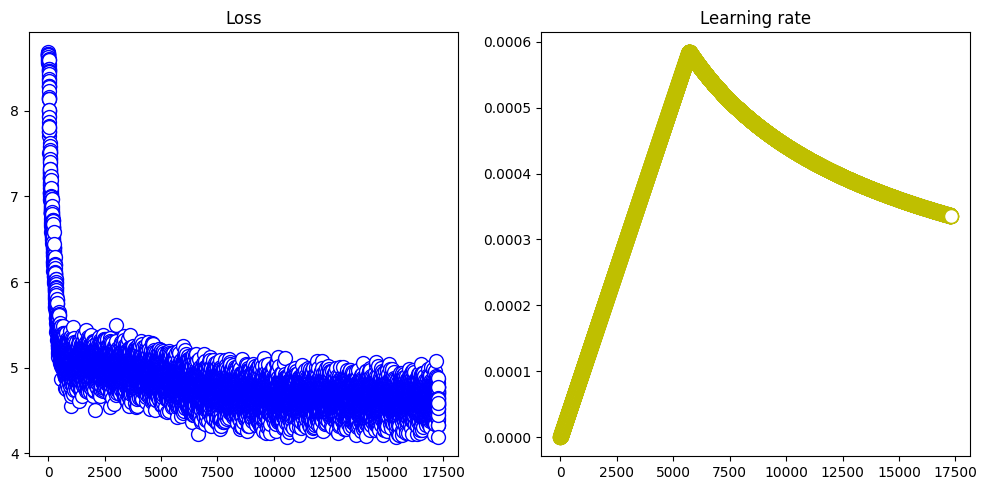

In [61]:

LOSS = []
LR   = []

for epoch in range(epochs):

    # train(train_loader, transformer, criterion, epoch)
    # train(train_loader, transformer, criterion, epoch, heads)
    # loss, lr = train(train_loader, transformer, criterion, epoch, heads)
    loss, lr = train(train_loader, transformer, criterion, epoch)

    LOSS.extend(loss)
    LR.extend(lr)


    # state = {'epoch': epoch, 'transformer': transformer, 'transformer_optimizer': transformer_optimizer}

    # # torch.save(state, f'checkpoint_' + str(epoch) + '.pth.tar')
    # torch.save(state, f'checkpoint_{str(epoch)}.pth.tar')


plot_loss_lr(LOSS, LR)



In [62]:

# checkpoint = torch.load(f'checkpoint_{epoch}.pth.tar')

# transformer = checkpoint['transformer']



In [63]:

while True:

    question = input("[In] >> ")

    if question == 'quit':
        break

    max_len = input("Maximum Reply Length >>: ")
    enc_qus = [word_map.get(word, word_map['<unk>'])  for word in question.split()]

    question = torch.LongTensor(enc_qus).to(device).unsqueeze(0)    # 2d dim, (batch_size, max_words) == (1, max_words)

    question_mask = (question != 0).to(device).unsqueeze(1).unsqueeze(1)    # 4d dim, as in creat_mask_function
                                                                            # (batch_size, 1, 1, max_words) == (1, 1, 1, max_words)


    sentence = evaluate(transformer, question, question_mask, int(max_len), word_map)
    print(sentence)




[In] >> tell me a joke
Maximum Reply Length >>: 15
i dont know
[In] >> quit
